In [101]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from abc import ABC, abstractmethod

class Agent(ABC):
    @abstractmethod
    def observe(self,state,action, next_state, reward):
    #call upon observing a new transtition of the environment
        pass

    @abstractmethod
    def select_action(self, state):
    #pick an action from the given state
        pass
        
    @abstractmethod  
    def update(self):
    #called after each environment step. This is wgere all the training takes place
        pass



Episode reward after taking random actions: -200.0


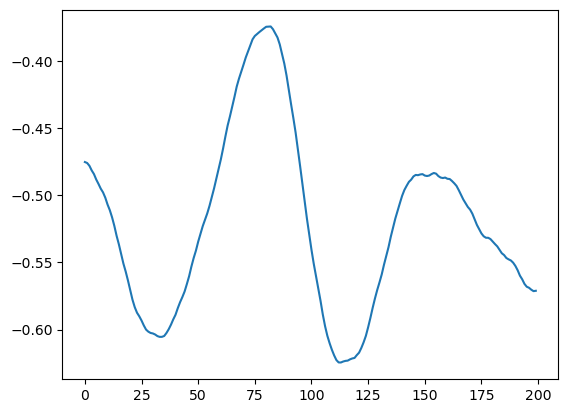

In [34]:
class RandomAgent:
    
    def select_action(self, state, env):
        return env.action_space.sample()
    
    def update(self, state, env):
        action = self.select_action(state, env)
        next_state, reward,terminated, truncated, _  = env.step(action)
        done = terminated or truncated

        return next_state,reward,done,

env = gym.make('MountainCar-v0')
random_agent = RandomAgent()
rewards = np.zeros(n_episodes)

state,_ = env.reset()
reward_epi = 0
done = False
x=[]
while not done:
    next_state,reward,end=random_agent.update(state, env)
    reward_epi += reward
    state=next_state
    x.append(state[0])
    done=end


env.close()

print(f"Episode reward after taking random actions: {reward_epi}")
plt.plot(x)

In [157]:
class DynaAgent:
    def __init__(self, discr_step=np.array([0.025, 0.005]), gamma=0.99, epsilon=0.9, min_epsilon=0.05, k=5):
    
        self.born_inf=env.observation_space.low
        self.born_sup=env.observation_space.high
        self.discr_step = discr_step
        self.n_states = ((self.born_sup - self.born_inf) / self.discr_step).astype(int)+1
        self.n_actions=env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.k = k
        
        # Initialize model components
        self.n_states_tot=self.n_states[0]*self.n_states[1]
        self.P_hat = np.ones(shape=(self.n_states_tot, self.n_actions, self.n_states_tot) )
        self.R_hat = np.zeros(shape=(self.n_states_tot,self. n_actions))
        self.Q = np.zeros(shape=(self.n_states_tot, self.n_actions))
        self.delta_Q=[]
        
    def discretize_state(self, state):
        discr_state = (state - self.born_inf) / np.array(self.discr_step)
        return tuple(discr_state.astype(int))
        
    def encode_state(self,state):
     
        return state[0]+self.n_states[0]*state[1]
    
    def update_model(self, state, action, reward, next_state):
        discr_state = self.discretize_state(state)
        discr_next_state = self.discretize_state(next_state)
        
        # Update transition probabilities

        self.P_hat[self.encode_state(discr_state)][action][self.encode_state(discr_next_state)] += 1
        
        # Update rewards
        self.R_hat[self.encode_state(discr_state)][action] += reward
    
    def update_q_value(self, state, action):
        
        discr_state = self.discretize_state(state)
        current=self.encode_state(discr_state)

        # Update Q-value
        max_next_q_value = [np.max(self.Q[next]) for next in range(self.n_states_tot)]
        old=self.Q[current,action]
        second_term=self.gamma*np.dot(self.P_hat[current,action,:]/np.sum(self.P_hat[current,action,:]),max_next_q_value)
        update=self.R_hat[current, action]+second_term
        self.delta_Q.append(update-old)
        self.Q[current,action]=update
        
    def update(self, state, action, reward, next_state):
        
        self.update_model(state, action, reward, next_state)
        self.update_q_value(state, action)
        
        # Perform further updates for k randomly chosen state-action pairs
        for _ in range(self.k):
            rand_state = np.array([random.uniform(self.born_inf[0], self.born_sup[0]),random.uniform(self.born_inf[1], self.born_sup[1])])
            rand_state=np.round(rand_state, 2)
            rand_action = np.random.randint(self.n_actions)
            self.update_q_value(rand_state, rand_action)
            
        
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            discr_state = self.discretize_state(state)
            return np.argmax(self.Q[self.encode_state(discr_state)])
    
    def decay_epsilon(self, episode):
        self.epsilon = max(self.min_epsilon, self.epsilon * (0.99 ** episode))

    def plot_delta_Q(self):
        plt.plot(self.delta_Q)
        plt.title('Q_value update step')
        plt.show()
        
    def plot_max_Q(self):
        max_Q_values = np.zeros((self.n_states[0], self.n_states[1]))
    
        for i in range(self.n_states[0]):
            for j in range(self.n_states[1]):
                state = (self.born_inf[0] + i * self.discr_step[0], self.born_inf[1] + j * self.discr_step[1])
                discr_state = self.discretize_state(state)
                max_Q_values[i][j] = np.max(self.Q[self.encode_state(discr_state)])
    
        plt.imshow(max_Q_values.T, origin='lower', extent=[self.born_inf[0], self.born_sup[0], self.born_inf[1], self.born_sup[1]])
        plt.colorbar(label='Max Q-value')
        plt.xlabel('Position')
        plt.ylabel('Velocity')
        plt.title('Max Q-values after learning')
        plt.show()
    

            
    
        

episode 0 : solved? : False
episode 2 : solved? : False
episode 4 : solved? : False
episode 6 : solved? : False
episode 8 : solved? : False


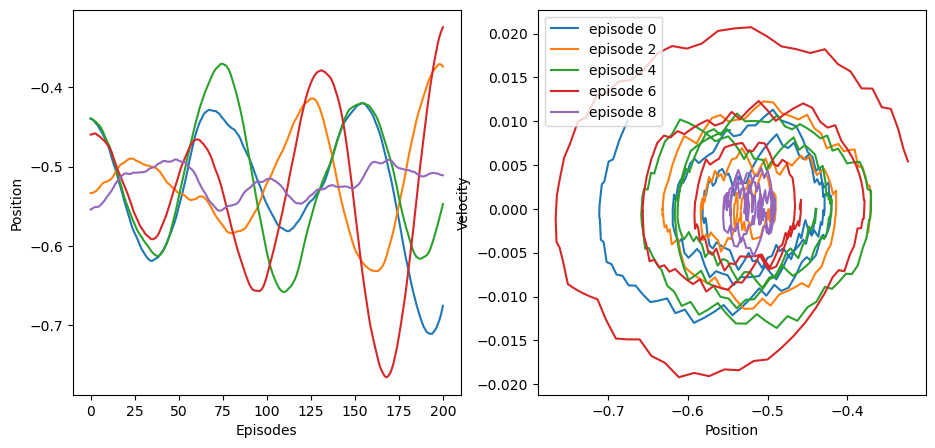

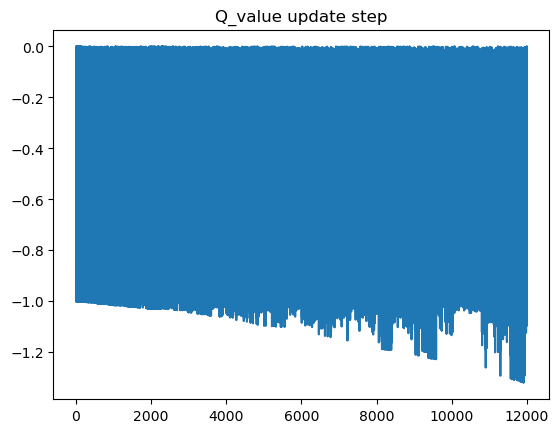

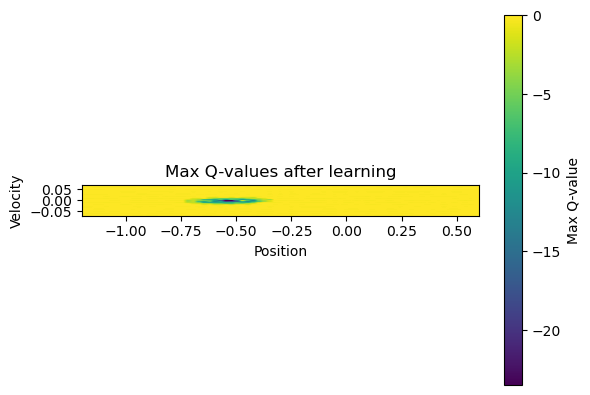

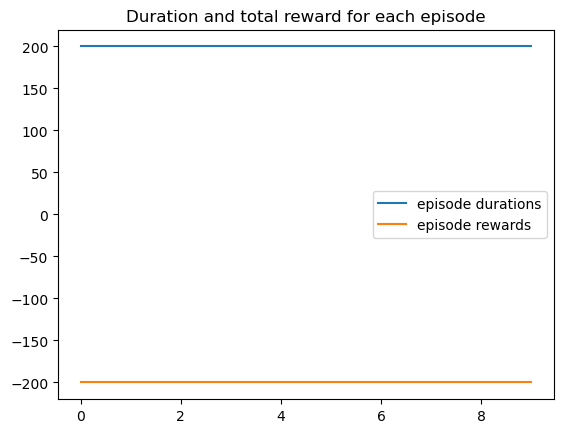

In [159]:

# Create the environment
env = gym.make('MountainCar-v0')
# Create the DynaAgent
dyna_agent = DynaAgent()

# Train the agent
n_episodes = 10
episode_rewards=[]
episode_durations = []

fig,ax=plt.subplots(1,2,figsize=(11,5))

for episode in range(n_episodes):
    state,_ = env.reset()
    total_reward = 0
    solved=False
    done = False
    x=[state[0]]
    v=[state[1]]
    n_itr=0
    while not done:
        action = dyna_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        dyna_agent.update(state, action, reward, next_state)
        solved=terminated
        done= terminated or truncated
        state = next_state
        total_reward += reward
        n_itr+=1
        x.append(state[0])  
        v.append(state[1])

    dyna_agent.decay_epsilon(episode)
    
    episode_rewards.append(total_reward) 
    episode_durations.append(n_itr)
    
    if (episode%2==0):
        ax[0].plot(list(range(n_itr+1)),x, label=f'episode {episode}')
        ax[1].plot(x,v, label=f'episode {episode}')
        print(f'episode {episode} : solved? : {solved}')

env.close()
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Position')
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Velocity')
plt.legend()
plt.show()

dyna_agent.plot_delta_Q()
dyna_agent.plot_max_Q()

plt.plot(list(range(n_episodes)),episode_durations, label='episode durations')
plt.plot(list(range(n_episodes)),episode_rewards,label='episode rewards')
plt.title('Duration and total reward for each episode' )
plt.legend()

